In [39]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import tree
from matplotlib import pyplot as plt
from scipy.stats import norm
import scipy.special
import seaborn as sns

In [135]:
"""
b:= number of paths
m:= length of path
max_depth:= max depth of trees
S_0:= initial stock price
K:= strike price
T:= time to maturity in years
freq:= depth of binomial tree per Bermudan period
gbm_freq:= number of discrete steps in calculating stock price per Bermudan period
"""
b = 10000
m = 10
maxdepth = 10
S_0 = 10
mu = 0.01
sigma = .3
option_type = "put"
T = 1
K = 12
freq = 1000
gbm_freq = 100

In [141]:
def gbm(S_0, mu, sigma, steps, b):
    result = np.full((steps+1, b), S_0, dtype = 'float64')
    rands = np.random.normal(scale = np.sqrt(T/steps),size=(steps, b))
    cum_rands = np.zeros((steps+1, b))
    endpoints = np.zeros((b))
    for i in range(1,steps+1):
        #if (100*i)%steps == 0:
            #print(100*i//steps,"out of 100")
        cum_rands[i,:] = cum_rands[i-1,:] + rands[i-1,:]
        for j in range(b):
            result[i,j] = S_0*np.exp((mu-(sigma**2)/2)*(T/steps)*i + sigma*(cum_rands[i,j]))
            
    return result

In [137]:
def option_value(t,S,option_type,K,r,T,m):
    if option_type == "call":
        return np.where(S > K, (S-K)*np.exp(r*T*(-t/m)), 0)
    elif option_type == "put":
        return np.where(S > K, 0, (K-S)*np.exp(r*T*(-t/m)))

In [138]:
def blackscholes_pred(option_type):
    bermudan_factor = np.exp(0.5*(np.exp(mu*T*(1-1/m))-1)*(1-mu)*T)
    #print("bermudan factor:", bermudan_factor)
    d1 = (np.log(S_0/K) + (mu + (sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == "call":
        result = S_0*norm.cdf(d1) - K*np.exp(-mu*T)*norm.cdf(d2)
        result = result
    elif option_type == "put":
        result = K*np.exp(-mu*T)*norm.cdf(-d2) - S_0*norm.cdf(-d1) 
        #print('result')
        result = result
    return result, result*bermudan_factor

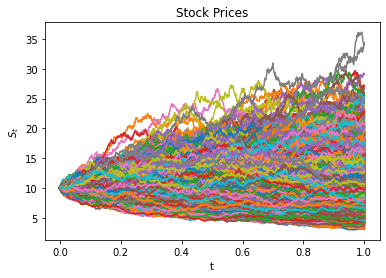

In [165]:
X = gbm(S_0, mu, sigma, m*gbm_freq, b)
t = np.linspace(0, T, m*gbm_freq+1)
plt.title("Stock Prices")
plt.xlabel("t")
plt.ylabel("$S_{t}$")
plt.plot(t,X);

In [153]:
def binomialtree(freq,sigma,m,S_0,option_type,K,r,T):
    exercise_histogram = np.zeros((m+1))
    exercise_count = 0
    #freq is steps per period
    u = np.exp(np.sqrt(T/(freq*m))*sigma)
    #print("potential overflow in binomial tree:", u**(100*100))
    d = 1/u
    p = (np.exp(mu*T/(freq*m))-d)/(u-d)
    if p < 0 or p > 1:
        raise Exception("Invalid probability for binomial tree")
    tree = np.zeros((m*freq+1,m*freq+1))
    for j in range(m*freq+1):
        #print("potential overflow:",u**j)
        S = S_0*(u**(2*j-m*freq))
        #print("Stock price at last branch in binomial tree: ",S)
        tree[m*freq,j] = option_value(m,S,option_type,K,r,T,m)
    #print(tree[-1])
    for i in range(m*freq-1,-1,-1):
        for j in range(i+1):
            if (i%freq) != 0:
                tree[i,j] = p*tree[i+1,j+1]+(1-p)*(tree[i+1,j])
            else:
                S = S_0*(u**(2*j-i))
                exerciseval = option_value(i//freq,S,option_type,K,r,T,m)
                if exerciseval > p*tree[i+1,j+1]+(1-p)*(tree[i+1,j]):
                    tree[i,j] = exerciseval
                    exercise_histogram[i//freq] += 2**(m-i)
                    exercise_count += 2**(m-i)
                else:
                    tree[i,j] = p*tree[i+1,j+1]+(1-p)*(tree[i+1,j])
    #print(tree)
    exercise_histogram[-1] = 2**m-exercise_count
    return tree[0,0],exercise_histogram

In [16]:
def euro_binomialtree(freq,sigma,m,S_0,option_type,K,r,T):
    #freq is steps per period
    u = np.exp(np.sqrt(T/(freq*m))*sigma)
    #print("potential overflow in binomial tree:", u**(100*100))
    d = 1/u
    p = (np.exp(mu*T/(freq*m))-d)/(u-d)
    if p < 0 or p > 1:
        raise Exception("Invalid probability for binomial tree")
    tree = np.zeros((m*freq+1,m*freq+1))
    for j in range(m*freq+1):
        #print("potential overflow:",u**j)
        S = S_0*(u**(2*j-m*freq))
        #print("Stock price at last branch in binomial tree: ",S)
        tree[m*freq,j] = option_value(m,S,option_type,K,r,T,m)
    #print("here", tree[-1])
    for i in range(m*freq-1,-1,-1):
        for j in range(i+1):
            if True:
                tree[i,j] = p*tree[i+1,j+1]+(1-p)*(tree[i+1,j])
    #print(tree)
    return tree[0,0],tree

In [154]:
#base case
V_hat = np.zeros((m+1,b))
V_hat[m,:] = option_value(m,X[-1,:],option_type,K,mu,T,m)
exercise_histogram = np.zeros((m+1))
exercise_count = 0

#inductive step
for t in range(m-1,-1,-1):
    current_tree = DecisionTreeRegressor(max_depth = maxdepth)
    current_tree.fit(X[t*gbm_freq].reshape(-1,1),V_hat[t+1])
    exercisevals = option_value(t,X[t*gbm_freq],option_type,K,mu,T,m)
    tree_preds = current_tree.predict(X[t*gbm_freq].reshape(-1,1))
    for j in range(b):
        if exercisevals[j] > tree_preds[j]:
            V_hat[t,j] = exercisevals[j]
            exercise_count += 1
            exercise_histogram[t] += 1
        else:
            V_hat[t,j] = tree_preds[j]

exercise_histogram[-1] = b-exercise_count
binomialtree_pred, tree_histogram = binomialtree(freq,sigma,m,S_0,option_type,K,mu,T)
black_scholes_euro, black_scholes_bermudan = blackscholes_pred(option_type)
print("tree model prediction:", V_hat[0][0])
print("binomial tree prediction:", binomialtree_pred)
print("black scholes prediction European:", black_scholes_euro)
print("black scholes prediction Bermudan:", black_scholes_bermudan)

tree model prediction: 2.6551470463252858
binomial tree prediction: 2.471245006531153
black scholes prediction European: 2.452036443079498
black scholes prediction Bermudan: 2.4630341600685495


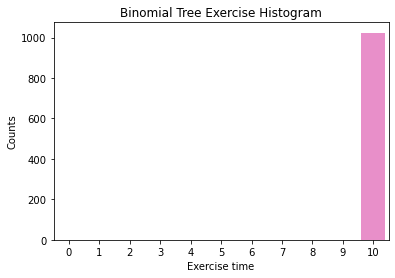

[0.0000000e+000 4.2718089e-296 0.0000000e+000 0.0000000e+000
 0.0000000e+000 0.0000000e+000 0.0000000e+000 0.0000000e+000
 0.0000000e+000 0.0000000e+000 1.0240000e+003]


In [162]:
ax= sns.barplot(x=np.arange(m+1),y=tree_histogram,ci=None)
ax.set(xlabel='Exercise time', ylabel='Counts', title='Binomial Tree Exercise Histogram')
plt.show()
print(tree_histogram)

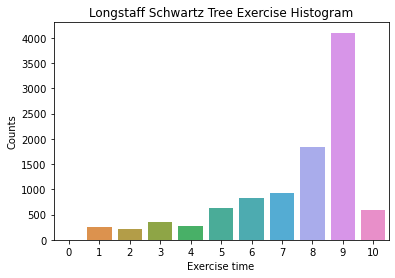

[   0.  244.  210.  356.  265.  626.  822.  937. 1837. 4104.  599.]


In [164]:
ax=sns.barplot(x=np.arange(m+1),y=exercise_histogram,ci=None)
ax.set(xlabel='Exercise time', ylabel='Counts', title='Longstaff Schwartz Tree Exercise Histogram')
plt.show()
print(exercise_histogram)